#  Analysis BitCoin Data Using ARIMA Models


Import the required library

In [1]:
import os
import sys

from pandas import read_csv
from pandas import datetime

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Create a function to plot the data

In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

We will apply ARIMA on Bitcoin Hourly data 

In [9]:
def parser(x):
	return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
series = read_csv('gemini_BTCUSD_1hr.csv', header=1, parse_dates=[1],
                  index_col=1,squeeze=True, date_parser=parser)

cols = ['Symbol', 'Unix Timestamp',
        'Open', 'High', 'Low', 'Volume']
series.drop(cols, axis=1, inplace=True)
series = series.sort_values('Date')
series.isnull().sum()


data = series

#log returns

lrets = np.log(data/data.shift(1))
lrets.dropna()

,Close
Date,
2015-10-08 14:00:00,0.000000
2015-10-08 15:00:00,-0.000327
2015-10-08 16:00:00,-0.002739
2015-10-08 17:00:00,0.003025
2015-10-08 18:00:00,-0.004049
2015-10-08 19:00:00,0.000000
2015-10-08 20:00:00,0.000000
2015-10-08 21:00:00,-0.000205
2015-10-08 22:00:00,0.000000


I will not include the data before 2016 becuase it doesn't have any seasonality or irregularity

I will set the training set between 2017 to 13 March 2019

In [53]:
lenseries = len(series)

start, end = pd.to_datetime(["2019-01-14 00:00:00", "2019-03-14 14:00:00"], 
                            format='%Y-%m-%d %H:%M:%S')
#(series >= start) & (series <= end)
trainingset = series[start : end]
trainingset

,Close
Date,
2019-01-14 00:00:00,3514.99
2019-01-14 01:00:00,3520.24
2019-01-14 02:00:00,3521.73
2019-01-14 03:00:00,3520.25
2019-01-14 04:00:00,3529.33
2019-01-14 05:00:00,3533.22
2019-01-14 06:00:00,3542.00
2019-01-14 07:00:00,3536.58
2019-01-14 08:00:00,3534.81


In [25]:
# log returns
lretsTrain = np.log(trainingset/trainingset.shift(1))
lretsTrain.dropna()

,Close
Date,
2019-01-14 01:00:00,0.001492
2019-01-14 02:00:00,0.000423
2019-01-14 03:00:00,-0.000420
2019-01-14 04:00:00,0.002576
2019-01-14 05:00:00,0.001102
2019-01-14 06:00:00,0.002482
2019-01-14 07:00:00,-0.001531
2019-01-14 08:00:00,-0.000501
2019-01-14 09:00:00,0.000054


Test data is between (2019-03-14) and (2019-03-21) in order to match the data from twitter

In [27]:
start_t, end_t = pd.to_datetime(["2019-03-14 14:00:00", "2019-03-21 00:00:00"], 
                            format='%Y-%m-%d %H:%M:%S')
testset = series[start_t : end_t] 


Fit ARIMA(p, d, q) model to BTC log returns

pick best order and final model based on AIC

aic: -11561.88137 | order: (3, 0, 2)


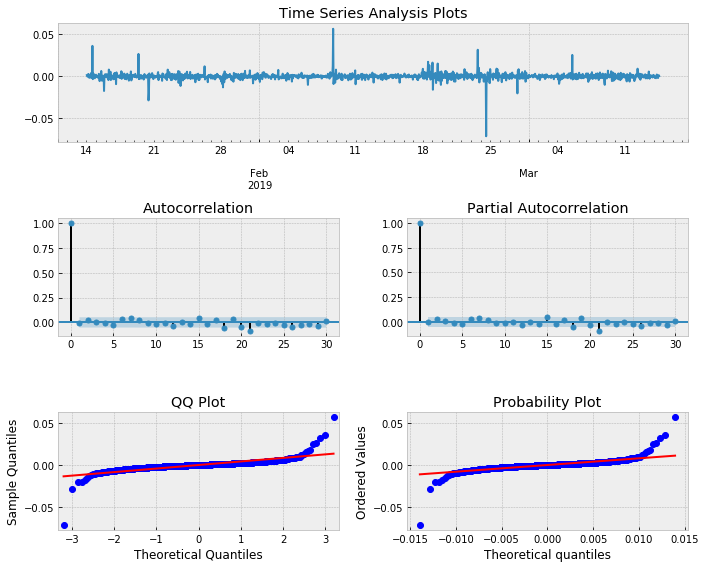

In [87]:
TS = lretsTrain['Close'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(1,4) # [1,2,3,5]
#d_rng = range(2) # [0,1]
for i in pq_rng:
    for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,0,j),freq= 'h').fit(trend='c')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, 0, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

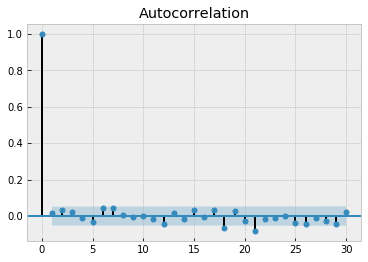

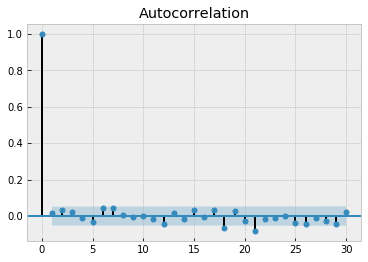

In [66]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(best_mdl.resid, lags = 30)

In [88]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[30], boxpierce=False)

(array([39.52898312]), array([0.11431396]))

In [96]:
from statsmodels import stats
stats.stattools.jarque_bera(best_mdl.resid)
 
# https://stats.stackexchange.com/questions/79400/does-arima-require-normally-distributed-errors-or-normally-distributed-input-dat
#explanation of not normal distribution 

(468967.3118518362, 0.0, -0.9885136510888803, 91.69538557387436)

#### Forecasting

We use statmodels forecast() method - we need to provide the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [190]:
# Create a 24 hours forecast of Bitcoin returns with 95%, 99% CI
n_steps = 24

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(lretsTrain.index[-1], periods=n_steps, freq='H')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast log return', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all

,forecast log return,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2019-03-14 14:00:00,-0.000199,-0.008481,-0.011083,0.008082,0.010684
2019-03-14 15:00:00,0.000122,-0.008163,-0.010766,0.008406,0.011009
2019-03-14 16:00:00,0.000313,-0.007972,-0.010575,0.008598,0.011201
2019-03-14 17:00:00,-0.000120,-0.008405,-0.011009,0.008166,0.010769
2019-03-14 18:00:00,-0.000088,-0.008374,-0.010978,0.008198,0.010802
2019-03-14 19:00:00,0.000323,-0.007963,-0.010567,0.008609,0.011213
2019-03-14 20:00:00,0.000082,-0.008205,-0.010809,0.008369,0.010973
2019-03-14 21:00:00,-0.000201,-0.008488,-0.011092,0.008086,0.010690
2019-03-14 22:00:00,0.000182,-0.008106,-0.010710,0.008469,0.011074
2019-03-14 23:00:00,0.000266,-0.008023,-0.010627,0.008554,0.011158


Plot 6 hours forecast for bitcoin returns

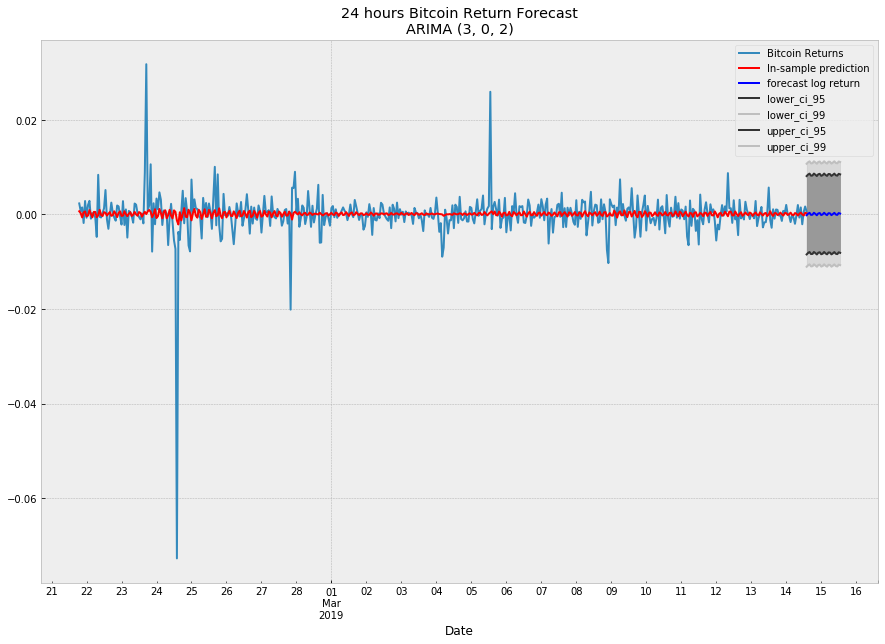

In [191]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = lretsTrain['Close'].iloc[-500:].copy()
ts.plot(ax=ax, label='Bitcoin Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} hours Bitcoin Return Forecast\nARIMA {}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

### plot the price in the next six hours

In [192]:
def value_check(x):
    if x >= 0 :
        return "P"
    else:
        return "N"
    

my_list = []
fc_all['Actual Price'] = testset['Close']

for x in fc_all["forecast log return"]:
     my_list.append(value_check(x))
fc_all['sign'] = my_list

fc_all

,forecast log return,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99,Actual Price,sign
2019-03-14 14:00:00,-0.000199,-0.008481,-0.011083,0.008082,0.010684,3852.22,N
2019-03-14 15:00:00,0.000122,-0.008163,-0.010766,0.008406,0.011009,3855.95,P
2019-03-14 16:00:00,0.000313,-0.007972,-0.010575,0.008598,0.011201,3849.07,P
2019-03-14 17:00:00,-0.000120,-0.008405,-0.011009,0.008166,0.010769,3856.90,N
2019-03-14 18:00:00,-0.000088,-0.008374,-0.010978,0.008198,0.010802,3851.74,N
2019-03-14 19:00:00,0.000323,-0.007963,-0.010567,0.008609,0.011213,3850.97,P
2019-03-14 20:00:00,0.000082,-0.008205,-0.010809,0.008369,0.010973,3852.00,P
2019-03-14 21:00:00,-0.000201,-0.008488,-0.011092,0.008086,0.010690,3856.74,N
2019-03-14 22:00:00,0.000182,-0.008106,-0.010710,0.008469,0.011074,3854.92,P
2019-03-14 23:00:00,0.000266,-0.008023,-0.010627,0.008554,0.011158,3855.87,P


Save the result to CSV file

In [193]:
fc_all['Increased or Not'] = fc_all['Actual Price'] > fc_all['Actual Price'].shift()
fc_all['sign'] = fc_all['sign'].shift()
fc_all

,forecast log return,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99,Actual Price,sign,Increased or Not
2019-03-14 14:00:00,-0.000199,-0.008481,-0.011083,0.008082,0.010684,3852.22,NaN,False
2019-03-14 15:00:00,0.000122,-0.008163,-0.010766,0.008406,0.011009,3855.95,N,True
2019-03-14 16:00:00,0.000313,-0.007972,-0.010575,0.008598,0.011201,3849.07,P,False
2019-03-14 17:00:00,-0.000120,-0.008405,-0.011009,0.008166,0.010769,3856.90,P,True
2019-03-14 18:00:00,-0.000088,-0.008374,-0.010978,0.008198,0.010802,3851.74,N,False
2019-03-14 19:00:00,0.000323,-0.007963,-0.010567,0.008609,0.011213,3850.97,N,False
2019-03-14 20:00:00,0.000082,-0.008205,-0.010809,0.008369,0.010973,3852.00,P,True
2019-03-14 21:00:00,-0.000201,-0.008488,-0.011092,0.008086,0.010690,3856.74,P,True
2019-03-14 22:00:00,0.000182,-0.008106,-0.010710,0.008469,0.011074,3854.92,N,False
2019-03-14 23:00:00,0.000266,-0.008023,-0.010627,0.008554,0.011158,3855.87,P,True


In [212]:
def acc_check(x,y):
    if (x == "P" and y == True) or (x == "N" and y == False):
        return "Correct"
    else:
        return "Not Correct"

tmp_list = []

for x,y in fc_all[['sign','Increased or Not']].itertuples(index=False):
     tmp_list.append(acc_check(x,y))
fc_all['Prediction Accuracy'] = tmp_list

fc_all

,forecast log return,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99,Actual Price,sign,Increased or Not,Prediction Accuracy
2019-03-14 14:00:00,-0.000199,-0.008481,-0.011083,0.008082,0.010684,3852.22,NaN,False,Not Correct
2019-03-14 15:00:00,0.000122,-0.008163,-0.010766,0.008406,0.011009,3855.95,N,True,Not Correct
2019-03-14 16:00:00,0.000313,-0.007972,-0.010575,0.008598,0.011201,3849.07,P,False,Not Correct
2019-03-14 17:00:00,-0.000120,-0.008405,-0.011009,0.008166,0.010769,3856.90,P,True,Correct
2019-03-14 18:00:00,-0.000088,-0.008374,-0.010978,0.008198,0.010802,3851.74,N,False,Correct
2019-03-14 19:00:00,0.000323,-0.007963,-0.010567,0.008609,0.011213,3850.97,N,False,Correct
2019-03-14 20:00:00,0.000082,-0.008205,-0.010809,0.008369,0.010973,3852.00,P,True,Correct
2019-03-14 21:00:00,-0.000201,-0.008488,-0.011092,0.008086,0.010690,3856.74,P,True,Correct
2019-03-14 22:00:00,0.000182,-0.008106,-0.010710,0.008469,0.011074,3854.92,N,False,Correct
2019-03-14 23:00:00,0.000266,-0.008023,-0.010627,0.008554,0.011158,3855.87,P,True,Correct


In [213]:
fc_all.to_csv('forcecast_bitcoin.csv', index = None, header=True)